In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tsfresh import select_features

In [104]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import RidgeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [105]:
feature_df = pd.read_csv('features_wo_norm.csv')
dir_df = pd.read_csv('directory.csv')

In [107]:
feature_df.head()

,Unnamed: 0,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,value__mean,value__length,value__standard_deviation,value__variation_coefficient,value__variance,value__skewness,value__kurtosis,value__root_mean_square,value__absolute_sum_of_changes,value__longest_strike_below_mean,value__longest_strike_above_mean,value__count_above_mean,value__count_below_mean,value__last_location_of_maximum,value__first_location_of_maximum,value__last_location_of_minimum,value__first_location_of_minimum,value__percentage_of_reoccurring_values_to_all_values,value__percentage_of_reoccurring_datapoints_to_all_datapoints,value__sum_of_reoccurring_values,value__sum_of_reoccurring_data_points,value__ratio_value_number_to_time_series_length,value__sample_entropy,value__maximum,value__absolute_maximum,value__minimum,value__benford_correlation,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,...,value__energy_ratio_by_chunks__num_segments_10__segment_focus_3,value__energy_ratio_by_chunks__num_segments_10__segment_focus_4,value__energy_ratio_by_chunks__num_segments_10__segment_focus_5,value__energy_ratio_by_chunks__num_segments_10__segment_focus_6,value__energy_ratio_by_chunks__num_segments_10__segment_focus_7,value__energy_ratio_by_chunks__num_segments_10__segment_focus_8,value__energy_ratio_by_chunks__num_segments_10__segment_focus_9,value__ratio_beyond_r_sigma__r_0.5,value__ratio_beyond_r_sigma__r_1,value__ratio_beyond_r_sigma__r_1.5,value__ratio_beyond_r_sigma__r_2,value__ratio_beyond_r_sigma__r_2.5,value__ratio_beyond_r_sigma__r_3,value__ratio_beyond_r_sigma__r_5,value__ratio_beyond_r_sigma__r_6,value__ratio_beyond_r_sigma__r_7,value__ratio_beyond_r_sigma__r_10,value__count_above__t_0,value__count_below__t_0,value__lempel_ziv_complexity__bins_2,value__lempel_ziv_complexity__bins_3,value__lempel_ziv_complexity__bins_5,value__lempel_ziv_complexity__bins_10,value__lempel_ziv_complexity__bins_100,value__fourier_entropy__bins_2,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7,signal_name,target_original,target,target_encoded
0,0,0.0,0.0,0.0,0.0,-8.049606,6.399184,0.016795,-0.000214,0.000019,-0.085321,-0.040655,198.0,0.175118,-4.307461,0.030666,4.228336,19.738346,0.179775,3.308647,111.0,31.0,47.0,151.0,0.393939,0.388889,0.348485,0.343434,0.0,0.0,0.0,0.0,1.0,0.037336,0.988435,0.988435,-0.264374,0.225955,0.000015,0.000104,...,0.769929,0.077919,0.030097,0.026151,0.021952,0.026315,0.014176,0.121212,0.080808,0.040404,0.040404,0.040404,0.030303,0.020202,0.000000,0.000000,0.0,0.191919,0.808081,0.116162,0.121212,0.161616,0.196970,0.434343,0.366925,0.509696,0.637149,0.836641,1.193074,1.174847,1.697517,2.230373,2.794168,3.286209,0.0,0.777912,100,+,Q,4
1,1,0.0,0.0,0.0,0.0,-7.168980,6.422554,0.013381,-0.000111,-0.000001,-0.078328,-0.027895,257.0,0.155603,-5.578203,0.024212,4.399534,23.460393,0.158084,3.425611,113.0,62.0,103.0,154.0,0.303502,0.299611,0.268482,0.264591,0.0,0.0,0.0,0.0,1.0,0.046844,0.988435,0.988435,-0.264374,0.537658,0.000011,0.000080,...,0.277747,0.036708,0.030813,0.034978,0.010443,0.002442,0.000385,0.116732,0.066148,0.038911,0.031128,0.031128,0.023346,0.015564,0.007782,0.000000,0.0,0.342412,0.657588,0.101167,0.105058,0.143969,0.171206,0.400778,0.359445,0.499973,0.663028,0.868198,1.301086,1.162903,1.659906,2.171393,2.712120,3.211305,0.0,0.777912,100,N,N,0
2,2,0.0,0.0,0.0,0.0,2.243733,9.919902,0.011209,0

In [108]:
feature_df = feature_df.iloc[:,1:]

In [109]:
X_train, X_test, y_train, y_test = train_test_split(np.array(feature_df.iloc[:, :-4]), np.array(feature_df.iloc[:,-1]), test_size=0.2, random_state=42, stratify=np.array(feature_df.iloc[:,-1]))

In [110]:
selected_feature_df = select_features(pd.DataFrame(X_train, columns=feature_df.iloc[:,:-4].columns.values), pd.Series(y_train))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(selected_feature_df)
ridge = RidgeClassifier(alpha=0.5)


ridge.fit(X_train_scaled, y_train)

coeff = np.abs(ridge.coef_)
meanC = np.mean(coeff, axis=0)
thresh = np.percentile(meanC, 90)
selected = selected_feature_df.columns[meanC > thresh]

X_train_reduced = np.array(selected_feature_df[selected])

X_test_reduced = pd.DataFrame(X_test, columns=feature_df.iloc[:,:-4].columns.values)
X_test_reduced = np.array(X_test_reduced[selected])

In [ ]:
xt = selected_feature_df[selected].copy()
xt.loc[:,'target'] = y_train
xt.to_csv('X_train_reduced_wo_norm.csv')
a = pd.DataFrame(X_test, columns=feature_df.iloc[:,:-4].columns.values)
a = a[selected]
a.loc[:,'target'] = y_test
a.to_csv('X_test_reduced_wo_norm.csv')


In [111]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def confusion_matrix_plot(y_true, y_pred):
    class_labels = ['N', 'S', 'V', 'F', 'Q']
    label_mapping = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

    # Ensure correct mapping from numbers to labels
    if isinstance(y_true[0], int) or isinstance(y_true[0], np.integer):
        y_true_labels = [label_mapping[label] for label in y_true]
        y_pred_labels = [label_mapping[label] for label in y_pred]
    else:
        y_true_labels = y_true
        y_pred_labels = y_pred

    # Compute confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_labels)

    # Compute classification report (handling missing classes)
    report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels, labels=class_labels, zero_division=0)
    print("\nClassification Report:\n", report)

    # Plot heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')

In [64]:

def stratified_kfold_cv(X, y, model, n_splits=10):

    # Initialize StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize lists to store scores for each fold
    f1_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    scaler = StandardScaler()
    
    # Perform Stratified K-Fold Cross Validation
    for train_idx, val_idx in skf.split(X, y):
        # Get the training and validation sets for each fold
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)
        # Train the model
        model.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_val_pred = model.predict(X_val_fold)
        
        # Calculate Precision, Recall, F1 Score, and Accuracy for the current fold
        precision = precision_score(y_val_fold, y_val_pred, average='weighted')
        recall = recall_score(y_val_fold, y_val_pred, average='weighted')
        f1 = f1_score(y_val_fold, y_val_pred, average='weighted')
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        
        # Append the scores for the fold
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)
        
        print(f"Fold Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Calculate and print the average scores across all folds
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_accuracy = np.mean(accuracy_scores)

    print("\nAverage Scores across all folds:")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")

In [65]:
model_nb = GaussianNB()
stratified_kfold_cv(X_train_reduced, y_train, model_nb, n_splits=10)

Fold Accuracy: 0.7562, Precision: 0.8789, Recall: 0.7562, F1 Score: 0.8049
Fold Accuracy: 0.7551, Precision: 0.8799, Recall: 0.7551, F1 Score: 0.8032
Fold Accuracy: 0.7620, Precision: 0.8799, Recall: 0.7620, F1 Score: 0.8080
Fold Accuracy: 0.7697, Precision: 0.8901, Recall: 0.7697, F1 Score: 0.8158
Fold Accuracy: 0.7602, Precision: 0.8861, Recall: 0.7602, F1 Score: 0.8085
Fold Accuracy: 0.7678, Precision: 0.8809, Recall: 0.7678, F1 Score: 0.8119
Fold Accuracy: 0.7291, Precision: 0.8789, Recall: 0.7291, F1 Score: 0.7860
Fold Accuracy: 0.7415, Precision: 0.8817, Recall: 0.7415, F1 Score: 0.7952
Fold Accuracy: 0.7590, Precision: 0.8810, Recall: 0.7590, F1 Score: 0.8066
Fold Accuracy: 0.7723, Precision: 0.8852, Recall: 0.7723, F1 Score: 0.8161

Average Scores across all folds:
Average Accuracy: 0.7573
Average Precision: 0.8823
Average Recall: 0.7573
Average F1 Score: 0.8056


In [66]:
model_knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
stratified_kfold_cv(X_train_reduced, y_train, model_knn, n_splits=10)

Fold Accuracy: 0.9672, Precision: 0.9662, Recall: 0.9672, F1 Score: 0.9646
Fold Accuracy: 0.9673, Precision: 0.9662, Recall: 0.9673, F1 Score: 0.9651
Fold Accuracy: 0.9651, Precision: 0.9633, Recall: 0.9651, F1 Score: 0.9620
Fold Accuracy: 0.9707, Precision: 0.9699, Recall: 0.9707, F1 Score: 0.9687
Fold Accuracy: 0.9669, Precision: 0.9655, Recall: 0.9669, F1 Score: 0.9648
Fold Accuracy: 0.9690, Precision: 0.9678, Recall: 0.9690, F1 Score: 0.9670
Fold Accuracy: 0.9684, Precision: 0.9672, Recall: 0.9684, F1 Score: 0.9663
Fold Accuracy: 0.9665, Precision: 0.9653, Recall: 0.9665, F1 Score: 0.9637
Fold Accuracy: 0.9647, Precision: 0.9631, Recall: 0.9647, F1 Score: 0.9619
Fold Accuracy: 0.9672, Precision: 0.9664, Recall: 0.9672, F1 Score: 0.9645

Average Scores across all folds:
Average Accuracy: 0.9673
Average Precision: 0.9661
Average Recall: 0.9673
Average F1 Score: 0.9649


In [67]:
model_rf = RandomForestClassifier(n_estimators = 500, max_depth = 10, n_jobs=-1, random_state=42)
stratified_kfold_cv(X_train_reduced, y_train, model_rf, n_splits=10)

Fold Accuracy: 0.9501, Precision: 0.9487, Recall: 0.9501, F1 Score: 0.9419
Fold Accuracy: 0.9513, Precision: 0.9507, Recall: 0.9513, F1 Score: 0.9448
Fold Accuracy: 0.9518, Precision: 0.9522, Recall: 0.9518, F1 Score: 0.9445
Fold Accuracy: 0.9547, Precision: 0.9554, Recall: 0.9547, F1 Score: 0.9485
Fold Accuracy: 0.9571, Precision: 0.9574, Recall: 0.9571, F1 Score: 0.9518
Fold Accuracy: 0.9516, Precision: 0.9513, Recall: 0.9516, F1 Score: 0.9447
Fold Accuracy: 0.9528, Precision: 0.9531, Recall: 0.9528, F1 Score: 0.9464
Fold Accuracy: 0.9518, Precision: 0.9516, Recall: 0.9518, F1 Score: 0.9445
Fold Accuracy: 0.9532, Precision: 0.9527, Recall: 0.9532, F1 Score: 0.9462
Fold Accuracy: 0.9530, Precision: 0.9536, Recall: 0.9530, F1 Score: 0.9458

Average Scores across all folds:
Average Accuracy: 0.9527
Average Precision: 0.9527
Average Recall: 0.9527
Average F1 Score: 0.9459


In [68]:
model = SVC(kernel='rbf')
stratified_kfold_cv(X_train_reduced, y_train, model, n_splits=10)

Fold Accuracy: 0.9646, Precision: 0.9634, Recall: 0.9646, F1 Score: 0.9609
Fold Accuracy: 0.9670, Precision: 0.9662, Recall: 0.9670, F1 Score: 0.9645
Fold Accuracy: 0.9648, Precision: 0.9634, Recall: 0.9648, F1 Score: 0.9615
Fold Accuracy: 0.9711, Precision: 0.9705, Recall: 0.9711, F1 Score: 0.9688
Fold Accuracy: 0.9698, Precision: 0.9694, Recall: 0.9698, F1 Score: 0.9672
Fold Accuracy: 0.9683, Precision: 0.9675, Recall: 0.9683, F1 Score: 0.9658
Fold Accuracy: 0.9678, Precision: 0.9671, Recall: 0.9678, F1 Score: 0.9654
Fold Accuracy: 0.9660, Precision: 0.9650, Recall: 0.9660, F1 Score: 0.9630
Fold Accuracy: 0.9672, Precision: 0.9663, Recall: 0.9672, F1 Score: 0.9639
Fold Accuracy: 0.9681, Precision: 0.9675, Recall: 0.9681, F1 Score: 0.9649

Average Scores across all folds:
Average Accuracy: 0.9675
Average Precision: 0.9666
Average Recall: 0.9675
Average F1 Score: 0.9646


In [69]:
model = SVC(kernel='linear')
stratified_kfold_cv(X_train_reduced, y_train, model, n_splits=10)

Fold Accuracy: 0.9430, Precision: 0.9391, Recall: 0.9430, F1 Score: 0.9349
Fold Accuracy: 0.9448, Precision: 0.9416, Recall: 0.9448, F1 Score: 0.9383
Fold Accuracy: 0.9444, Precision: 0.9432, Recall: 0.9444, F1 Score: 0.9369
Fold Accuracy: 0.9485, Precision: 0.9464, Recall: 0.9485, F1 Score: 0.9431
Fold Accuracy: 0.9481, Precision: 0.9451, Recall: 0.9481, F1 Score: 0.9416
Fold Accuracy: 0.9481, Precision: 0.9450, Recall: 0.9481, F1 Score: 0.9421
Fold Accuracy: 0.9470, Precision: 0.9440, Recall: 0.9470, F1 Score: 0.9404
Fold Accuracy: 0.9431, Precision: 0.9391, Recall: 0.9431, F1 Score: 0.9359
Fold Accuracy: 0.9499, Precision: 0.9464, Recall: 0.9499, F1 Score: 0.9434
Fold Accuracy: 0.9478, Precision: 0.9457, Recall: 0.9478, F1 Score: 0.9410

Average Scores across all folds:
Average Accuracy: 0.9465
Average Precision: 0.9436
Average Recall: 0.9465
Average F1 Score: 0.9398


In [70]:
model = SVC(kernel='poly')
stratified_kfold_cv(X_train_reduced, y_train, model, n_splits=10)

Fold Accuracy: 0.9594, Precision: 0.9579, Recall: 0.9594, F1 Score: 0.9553
Fold Accuracy: 0.9608, Precision: 0.9596, Recall: 0.9608, F1 Score: 0.9573
Fold Accuracy: 0.9600, Precision: 0.9583, Recall: 0.9600, F1 Score: 0.9558
Fold Accuracy: 0.9635, Precision: 0.9617, Recall: 0.9635, F1 Score: 0.9604
Fold Accuracy: 0.9642, Precision: 0.9636, Recall: 0.9642, F1 Score: 0.9606
Fold Accuracy: 0.9617, Precision: 0.9606, Recall: 0.9617, F1 Score: 0.9581
Fold Accuracy: 0.9600, Precision: 0.9583, Recall: 0.9600, F1 Score: 0.9567
Fold Accuracy: 0.9589, Precision: 0.9570, Recall: 0.9589, F1 Score: 0.9543
Fold Accuracy: 0.9619, Precision: 0.9602, Recall: 0.9619, F1 Score: 0.9578
Fold Accuracy: 0.9629, Precision: 0.9615, Recall: 0.9629, F1 Score: 0.9595

Average Scores across all folds:
Average Accuracy: 0.9613
Average Precision: 0.9599
Average Recall: 0.9613
Average F1 Score: 0.9576


In [71]:
model = SVC(kernel='sigmoid')
stratified_kfold_cv(X_train_reduced, y_train, model, n_splits=10)

Fold Accuracy: 0.8285, Precision: 0.7997, Recall: 0.8285, F1 Score: 0.8137
Fold Accuracy: 0.8238, Precision: 0.8009, Recall: 0.8238, F1 Score: 0.8120
Fold Accuracy: 0.8266, Precision: 0.8007, Recall: 0.8266, F1 Score: 0.8134
Fold Accuracy: 0.8301, Precision: 0.8057, Recall: 0.8301, F1 Score: 0.8177
Fold Accuracy: 0.8259, Precision: 0.8025, Recall: 0.8259, F1 Score: 0.8138
Fold Accuracy: 0.8224, Precision: 0.7993, Recall: 0.8224, F1 Score: 0.8106
Fold Accuracy: 0.8210, Precision: 0.8009, Recall: 0.8210, F1 Score: 0.8107
Fold Accuracy: 0.8262, Precision: 0.7995, Recall: 0.8262, F1 Score: 0.8125
Fold Accuracy: 0.8282, Precision: 0.7982, Recall: 0.8282, F1 Score: 0.8127
Fold Accuracy: 0.8315, Precision: 0.8050, Recall: 0.8315, F1 Score: 0.8178

Average Scores across all folds:
Average Accuracy: 0.8264
Average Precision: 0.8013
Average Recall: 0.8264
Average F1 Score: 0.8135


In [112]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input, LSTM, Dense, Flatten, Dropout, BatchNormalization

In [113]:
def stratified_kfold_cv_nn(X, y, model, n_splits=10, batch_size=64, lstm=False):

    # Initialize StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize lists to store scores for each fold
    f1_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    scaler = StandardScaler()
    
    # Perform Stratified K-Fold Cross Validation
    for train_idx, val_idx in skf.split(X, y):
        # Get the training and validation sets for each fold
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)
        
        if lstm == True:
            # Reshape to (samples, timesteps, features)
            X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1], 1)
            X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], X_val_fold.shape[1], 1)
        
        # Train the model
        
        model.fit(
            X_train_fold, y_train_fold,
            epochs=20,
            batch_size=batch_size,
            validation_data=(X_val_fold, y_val_fold),
            verbose=0
        )
        
        # Predict on the validation fold
        y_val_pred = np.argmax(model.predict(X_val_fold), axis=1)
        
        # Calculate Precision, Recall, F1 Score, and Accuracy for the current fold
        precision = precision_score(y_val_fold, y_val_pred, average='weighted')
        recall = recall_score(y_val_fold, y_val_pred, average='weighted')
        f1 = f1_score(y_val_fold, y_val_pred, average='weighted')
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        
        # Append the scores for the fold
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)
        
        print(f"Fold Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Calculate and print the average scores across all folds
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_accuracy = np.mean(accuracy_scores)

    print("\nAverage Scores across all folds:")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")

In [83]:
model_mlp = Sequential([
    Input(shape=(X_train_reduced.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])


model_mlp.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_sizes = [64]
for bs in batch_sizes:
    print(f'model_mlp batch_size: {bs}')
    stratified_kfold_cv_nn(X_train_reduced, y_train, model_mlp, n_splits=10, batch_size=bs, lstm=False)
    print('*' * 20)

model_mlp batch_size: 64
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold Accuracy: 0.9716, Precision: 0.9706, Recall: 0.9716, F1 Score: 0.9709
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold Accuracy: 0.9805, Precision: 0.9802, Recall: 0.9805, F1 Score: 0.9802
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold Accuracy: 0.9814, Precision: 0.9812, Recall: 0.9814, F1 Score: 0.9810
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold Accuracy: 0.9860, Precision: 0.9859, Recall: 0.9860, F1 Score: 0.9859
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold Accuracy: 0.9860, Precision: 0.9860, Recall: 0.9860, F1 Score: 0.9859
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold Accuracy: 0.9898, Precision: 0.9898, Recall: 0.9898, F1 Score: 0.9897
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold Accuracy: 0.9898, Precision: 0.9896, Recall: 0.9898, F1 Score: 0.9896
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
Fold Accuracy: 0.9901, Precision: 0.9900, Recall: 0.9901, F1 Score: 0.9900
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [84]:
model_lstm = Sequential([
    Input(shape=(X_train_reduced.shape[1], 1)),


    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32),


    Dense(128, activation='relu'),
    
    Dense(5, activation='softmax')
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


for bs in batch_sizes:
    print(f'model_lstm batch_size: {bs}')
    stratified_kfold_cv_nn(X_train_reduced, y_train, model_lstm, n_splits=10, batch_size=bs, lstm=True)
    print('*' * 100)

model_lstm batch_size: 64
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
Fold Accuracy: 0.9616, Precision: 0.9591, Recall: 0.9616, F1 Score: 0.9591
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
Fold Accuracy: 0.9719, Precision: 0.9710, Recall: 0.9719, F1 Score: 0.9712
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
Fold Accuracy: 0.9782, Precision: 0.9777, Recall: 0.9782, F1 Score: 0.9775
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
Fold Accuracy: 0.9826, Precision: 0.9827, Recall: 0.9826, F1 Score: 0.9824
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
Fold Accuracy: 0.9899, Precision: 0.9898, Recall: 0.9899, F1 Score: 0.9898
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
Fold Accuracy: 0.9908, Precision: 0.9907, Recall: 0.9908, F1 Score: 0.9908
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
Fold Accuracy: 0.9942, Precision: 0.9942, Recall: 0.9942, F1 Score: 0.9942
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
Fold Accuracy: 0.9917, Precision: 0.9916, Recall: 0.9917, F1 Score: 0.9916
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/s

In [ ]:
model_cnn = Sequential([
    Input(shape=(X_train_reduced.shape[1], 1)),  # Ensure X_train_reduced.shape[1] matches the number of features

    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),  # Increased pool size to downsample the sequence length

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),  # Increased pool size

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # Output layer for 5 classes
])

model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

for bs in batch_sizes:
    print(f'model_mlp batch_size: {bs}')
    stratified_kfold_cv_nn(X_train_reduced, y_train, model_cnn, n_splits=10, batch_size=bs, lstm=True)
    print('*' * 100)

model_mlp batch_size: 64
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold Accuracy: 0.9681, Precision: 0.9673, Recall: 0.9681, F1 Score: 0.9675
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold Accuracy: 0.9834, Precision: 0.9833, Recall: 0.9834, F1 Score: 0.9833
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold Accuracy: 0.9883, Precision: 0.9880, Recall: 0.9883, F1 Score: 0.9880
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold Accuracy: 0.9917, Precision: 0.9916, Recall: 0.9917, F1 Score: 0.9916
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold Accuracy: 0.9942, Precision: 0.9942, Recall: 0.9942, F1 Score: 0.9942
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold Accuracy: 0.9967, Precision: 0.9967, Recall: 0.9967, F1 Score: 0.9967
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold A

In [114]:
model_cnn = Sequential([
    Input(shape=(X_train_reduced.shape[1], 1)),  # Ensure X_train_reduced.shape[1] matches the number of features

    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),  # Increased pool size to downsample the sequence length

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),  # Increased pool size

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # Output layer for 5 classes
])


model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [138]:
history = model_cnn.fit(
            X_train_reduced.reshape(X_train_reduced.shape[0], X_train_reduced.shape[1],1), y_train,
            epochs=20,
            batch_size=64,
            verbose=0
        )
y_pred = np.argmax(model_cnn.predict(X_test_reduced.reshape(X_test_reduced.shape[0], X_test_reduced.shape[1],1)), axis=1)

649/649 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step



Classification Report:
               precision    recall  f1-score   support

           N       0.98      0.99      0.98     18025
           S       0.91      0.77      0.84       556
           V       0.92      0.91      0.92      1402
           F       0.82      0.69      0.75       161
           Q       0.79      0.65      0.72       601

    accuracy                           0.97     20745
   macro avg       0.88      0.80      0.84     20745
weighted avg       0.97      0.97      0.97     20745



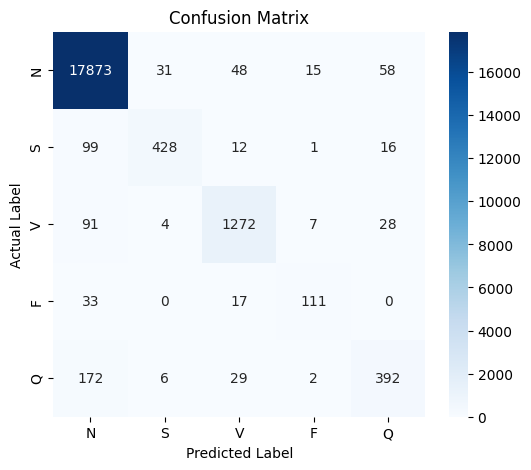

In [139]:
confusion_matrix_plot(y_test, y_pred)

In [140]:

def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training Accuracy')

    plt.show()


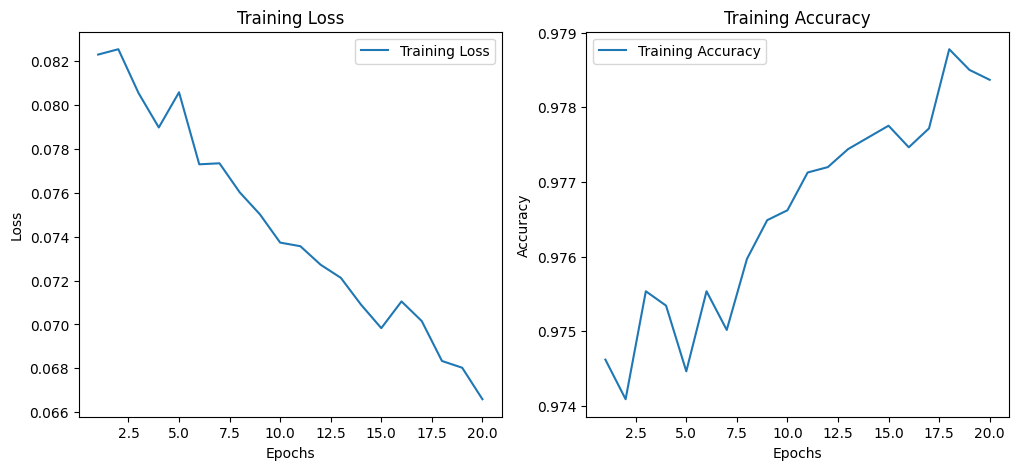

In [142]:
plot_history(history)